In [21]:
import xarray as xr

In [38]:
data_path = "/Users/fquareng/data/T_2M.nc"
data_path = "/Users/fquareng/data/1h_2D/lffd20101117110000.nz"

In [39]:
ds = xr.open_dataset(data_path, engine="netcdf4")

In [40]:
ds

<xarray.Dataset> Size: 438MB
Dimensions:          (time: 1, bnds: 2, rlon: 1542, rlat: 1542, level1: 61,
                      soil1: 10, windsector: 16)
Coordinates:
  * time             (time) datetime64[ns] 8B 2010-11-17T11:00:00
  * rlon             (rlon) float32 6kB -18.86 -18.84 -18.82 ... 11.94 11.96
  * rlat             (rlat) float32 6kB -14.86 -14.84 -14.82 ... 15.94 15.96
    lon              (rlat, rlon) float32 10MB ...
    lat              (rlat, rlon) float32 10MB ...
    height_2m        float32 4B ...
    height_10m       float32 4B ...
    height_toa       float32 4B ...
  * soil1            (soil1) float32 40B 0.005 0.025 0.07 ... 2.86 5.74 11.5
  * windsector       (windsector) float32 64B 0.0 22.5 45.0 ... 315.0 337.5
Dimensions without coordinates: bnds, level1
Data variables: (12/50)
    time_bnds        (time, bnds) datetime64[ns] 16B ...
    rotated_pole     |S1 1B ...
    vcoord           (level1) float32 244B ...
    wbtemp_13c       float32 4B ...
    soil1_bnds       (soil1, bnds) float32 80B ...
    windsector_bnds  (windsector, bnds) float32 128B ...
    ...               ...
    ATHB_S           (time, rlat, rlon) float32 10MB ...
    ATHD_S           (time, rlat, rlon) float32 10MB ...
    ATHU_S           (time, rlat, rlon) float32 10MB ...
    ALB_RAD          (time, rlat, rlon) float32 10MB ...
    HPBL             (time, rlat, rlon) float32 10MB ...
    HZEROCL          (time, rlat, rlon) float32 10MB ...
Attributes:
    title:           COSMO driven by 4 km COSMO
    source:          COSMO_5.08
    Conventions:     CF-1.4
    conventionsURL:  http://www.cfconventions.org/
    creation_date:   2023-05-29 06:25:08
    history:         Fri May 17 20:30:31 2024: ncks -4 -L 5 --no_abc -O /proj...
    NCO:             netCDF Operators version 5.0.4 (Homepage = http://nco.sf...

In [51]:
print(ds["lon"][0, 0].values)
print(ds["lon"][-1, -1].values)
print(ds["lat"][0, 0].values)
print(ds["lat"][-1, -1].values)

-11.061134
34.34347
29.606312
61.095375


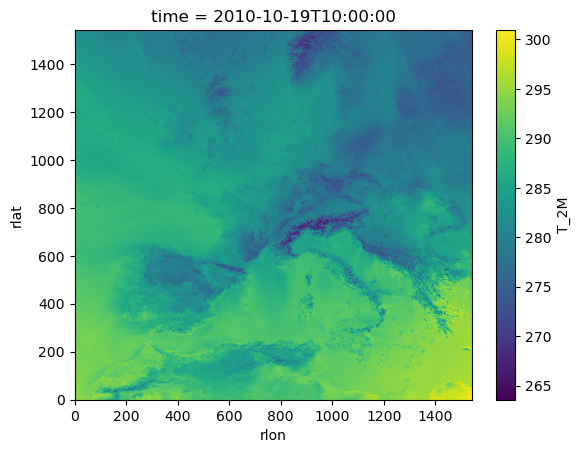

In [33]:
ds.T_2M.sel(time='2010-10-19T10:00:00').plot()

In [37]:
ds["rlat"]


<xarray.DataArray 'rlat' (rlat: 1542)> Size: 12kB
array([   0,    1,    2, ..., 1539, 1540, 1541])
Coordinates:
    lat      (rlat) float32 6kB ...
Dimensions without coordinates: rlat

{'driver': 'GTiff', 'dtype': 'float32', 'nodata': None, 'width': 21600, 'height': 32102, 'count': 1, 'crs': CRS.from_wkt('GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AXIS["Latitude",NORTH],AXIS["Longitude",EAST],AUTHORITY["EPSG","4326"]]'), 'transform': Affine(0.0008333333333333334, 0.0, 6.606249966666695,
       0.0, -0.0008333333333333334, 61.0954167)}


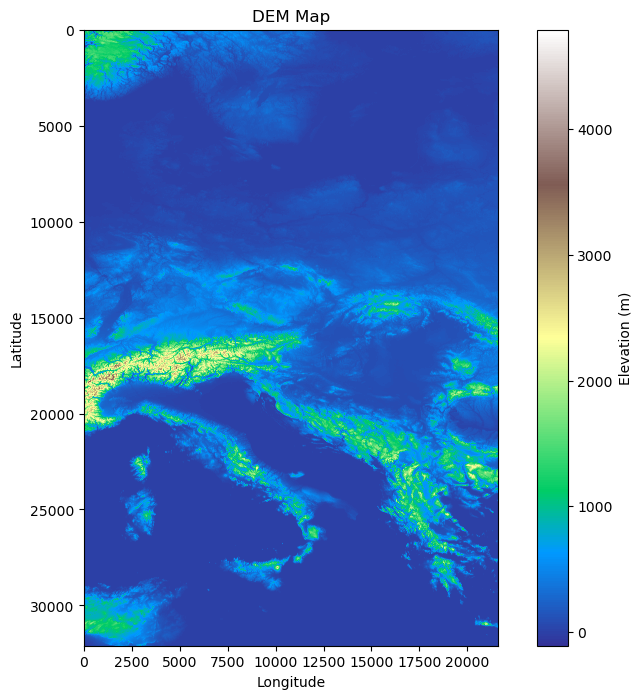

In [52]:
import rasterio
import matplotlib.pyplot as plt

# Open the .tiff file using rasterio
dem_file = '/Users/fquareng/data/output_hh 2.tif'
with rasterio.open(dem_file) as src:
    # Read the DEM data
    dem_data = src.read(1)  # Read the first band (assuming the DEM is single-band)

    # Get the metadata for the .tiff
    meta = src.meta
    print(meta)

# Plot the DEM data
plt.figure(figsize=(10, 8))
plt.imshow(dem_data, cmap='terrain', origin='upper')  # 'terrain' colormap for elevation
plt.colorbar(label='Elevation (m)')
plt.title('DEM Map')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

In [56]:
import rasterio
import numpy as np

def stitch_tiffs(input_files, output_file):
    # Open the input TIFF files using rasterio
    with rasterio.open(input_files[0]) as src:
        # Get metadata of the first file
        meta = src.meta
        # Read the first file's data
        data = src.read(1)  # Assuming single-band files; adjust if more bands are present
        
    # Loop through the remaining TIFF files and append their data
    for file in input_files[1:]:
        with rasterio.open(file) as src:
            # Read data from current TIFF file
            new_data = src.read(1)  # Assuming single-band files; adjust if more bands are present
            
            # Combine the data along the appropriate axis
            data = np.hstack((data, new_data))  # For horizontal stitching (side by side)
            # data = np.vstack((data, new_data))  # For vertical stitching (one on top of another)

    # Update the metadata for the output file (e.g., width, height, etc.)
    meta.update({
        'count': 1,  # Number of bands (adjust if you have more than 1 band)
        'height': data.shape[0],
        'width': data.shape[1]
    })

    # Write the stitched data to the output TIFF file
    with rasterio.open(output_file, 'w', **meta) as dst:
        dst.write(data, 1)  # Write to the first band (since we have single-band data)

    print(f"Stitched TIFF saved as: {output_file}")

# Example usage
input_files = [
    '/Users/fquareng/data/output_hh.tif',
    '/Users/fquareng/data/output_hh 2.tif',
    '/Users/fquareng/data/output_hh 3.tif',
]

output_file = '/Users/fquareng/data/europe_dem.tif'  # Path to save the new stitched TIFF

stitch_tiffs(input_files, output_file)

Stitched TIFF saved as: /Users/fquareng/data/europe_dem.tif


{'driver': 'GTiff', 'dtype': 'float32', 'nodata': None, 'width': 48728, 'height': 32102, 'count': 1, 'crs': CRS.from_wkt('GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AXIS["Latitude",NORTH],AXIS["Longitude",EAST],AUTHORITY["EPSG","4326"]]'), 'transform': Affine(0.0008333333333333334, 0.0, -11.000416699999988,
       0.0, -0.0008333333333333334, 61.0954167)}


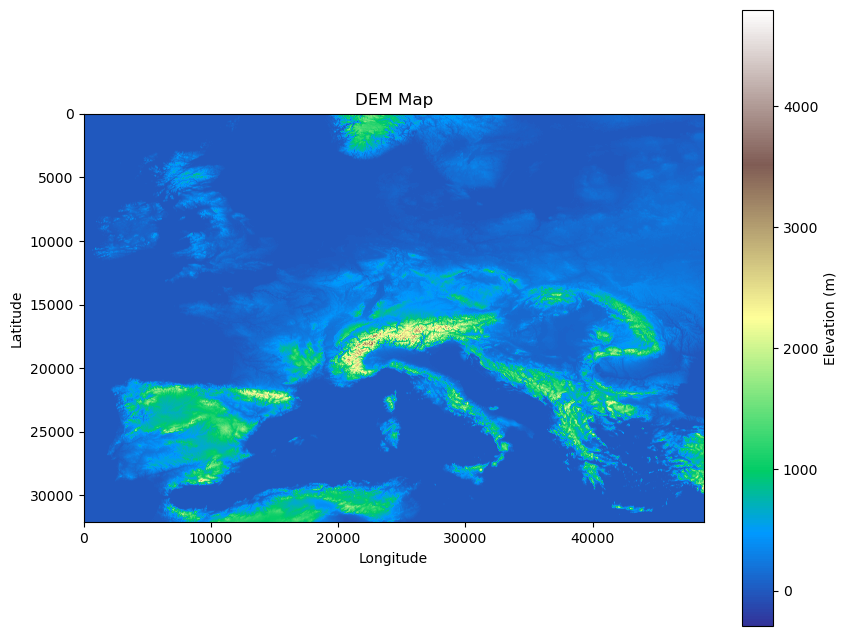

In [57]:
# Open the .tiff file using rasterio
dem_file = '/Users/fquareng/data/europe_dem.tif'
with rasterio.open(dem_file) as src:
    # Read the DEM data
    dem_data = src.read(1)  # Read the first band (assuming the DEM is single-band)

    # Get the metadata for the .tiff
    meta = src.meta
    print(meta)

# Plot the DEM data
plt.figure(figsize=(10, 8))
plt.imshow(dem_data, cmap='terrain', origin='upper')  # 'terrain' colormap for elevation
plt.colorbar(label='Elevation (m)')
plt.title('DEM Map')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

In [58]:
from rasterio.enums import Resampling

def downscale_tiff(input_file, output_file, new_lat, new_lon):
    with rasterio.open(input_file) as src:
        # Read original data and metadata
        data = src.read(1)  # Read the first band (adjust if there are multiple bands)
        transform = src.transform

        # Calculate new resolution based on new_lat and new_lon
        new_height = new_lat
        new_width = new_lon

        # Define the scale factors
        scale_factor_x = src.width / new_width
        scale_factor_y = src.height / new_height

        # Resample data using rasterio's built-in resampling
        resampled_data = src.read(
            out_shape=(src.count, new_height, new_width),  # Adjust dimensions
            resampling=Resampling.bilinear  # Choose the resampling method
        )

        # Update the transform for the new resolution
        new_transform = src.transform * src.transform.scale(
            (src.width / new_width),
            (src.height / new_height)
        )

        # Update metadata for the output file
        new_meta = src.meta.copy()
        new_meta.update({
            "height": new_height,
            "width": new_width,
            "transform": new_transform
        })

        # Write the downscaled data to a new TIFF file
        with rasterio.open(output_file, "w", **new_meta) as dst:
            dst.write(resampled_data)

    print(f"Downscaled TIFF saved as: {output_file}")

# Example usage
input_file = '/Users/fquareng/data/europe_dem.tif'  # Replace with your file path
output_file = '/Users/fquareng/data/europe_dem_low_res.tif'  # Path for the output file
new_lat = 1542  # Number of points in latitude (height)
new_lon = 1542  # Number of points in longitude (width)

downscale_tiff(input_file, output_file, new_lat, new_lon)

Downscaled TIFF saved as: /Users/fquareng/data/europe_dem_low_res.tif


{'driver': 'GTiff', 'dtype': 'float32', 'nodata': None, 'width': 1542, 'height': 1542, 'count': 1, 'crs': CRS.from_wkt('GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AXIS["Latitude",NORTH],AXIS["Longitude",EAST],AUTHORITY["EPSG","4326"]]'), 'transform': Affine(0.026333765672287075, 0.0, -11.000416699999988,
       0.0, -0.017348681366191096, 61.0954167)}


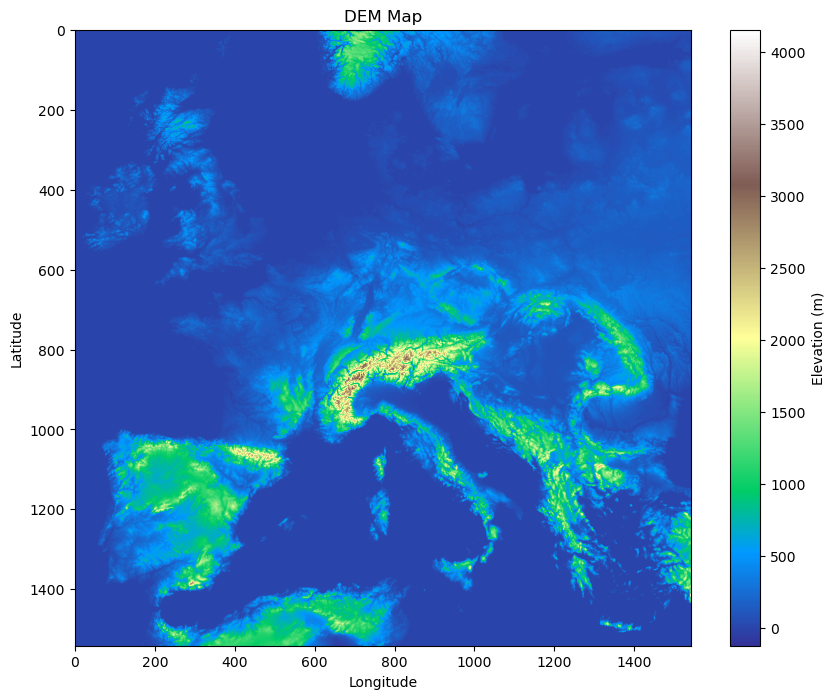

In [59]:
# Open the .tiff file using rasterio
dem_file = '/Users/fquareng/data/europe_dem_low_res.tif'
with rasterio.open(dem_file) as src:
    # Read the DEM data
    dem_data = src.read(1)  # Read the first band (assuming the DEM is single-band)

    # Get the metadata for the .tiff
    meta = src.meta
    print(meta)

# Plot the DEM data
plt.figure(figsize=(10, 8))
plt.imshow(dem_data, cmap='terrain', origin='upper')  # 'terrain' colormap for elevation
plt.colorbar(label='Elevation (m)')
plt.title('DEM Map')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

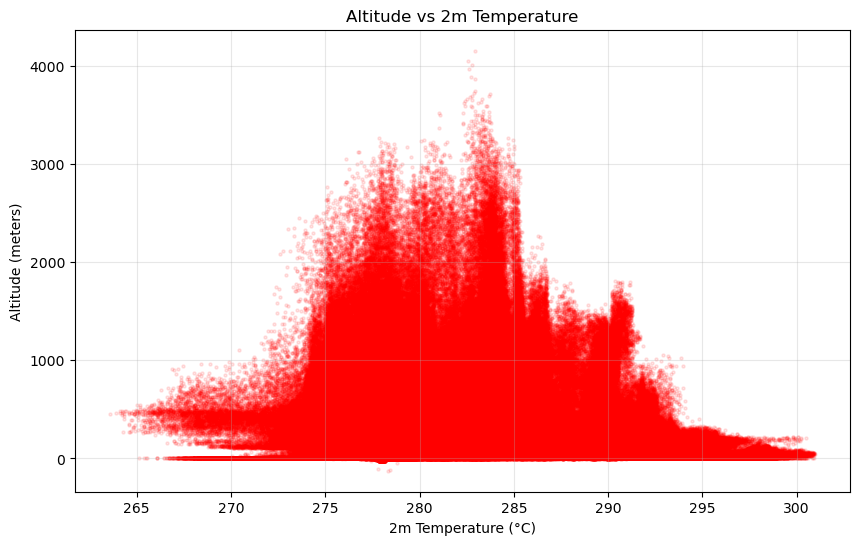

In [66]:
import rasterio
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt

def plot_altitude_vs_temperature(dem_file, temp_file, variable="T_2M", time_step=0):
    # Load DEM data
    with rasterio.open(dem_file) as dem_src:
        altitude = dem_src.read(1)  # Read the first (and usually only) band
        dem_transform = dem_src.transform

    # Load temperature data
    temp_ds = xr.open_dataset(temp_file)
    temperature = temp_ds[variable].isel(time=time_step).values  # Select the first time step

    # Check dimensions match
    if altitude.shape != temperature.shape:
        raise ValueError("Altitude and temperature dimensions do not match. Check input files.")

    # Flatten the 2D grid into 1D arrays
    altitude_flat = altitude.flatten()
    temperature_flat = temperature.flatten()

    # Remove NaN values (common in geospatial data)
    valid_mask = ~np.isnan(altitude_flat) & ~np.isnan(temperature_flat)
    altitude_flat = altitude_flat[valid_mask]
    temperature_flat = temperature_flat[valid_mask]

    # Scatter plot
    plt.figure(figsize=(10, 6))
    plt.scatter(temperature_flat, altitude_flat, s=5, alpha=0.1, c="red")
    plt.title("Altitude vs 2m Temperature")
    plt.ylabel("Altitude (meters)")
    plt.xlabel("2m Temperature (°C)")
    plt.grid(alpha=0.3)
    plt.show()

# Example usage
dem_file = '/Users/fquareng/data/europe_dem_low_res.tif'
temp_file = '/Users/fquareng/data/T_2M.nc'
plot_altitude_vs_temperature(dem_file, temp_file)